In [27]:
import itertools
import os
import pickle

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.rcParams.get("font.size")
plt.rcParams.update({'font.size': 14})

In [30]:
topology_name = "nsfnet"
# topology_name = "janos-us"
# topology_name = "germany50"
strategies = np.arange(1, 5)

launch_powers = np.linspace(-1, 1, num=5)

if topology_name == "nobel-eu":
    load = 210
    loads = np.arange(50, 651, 50)
elif topology_name == "germany50":
    load = 400
    loads = np.arange(300, 801, 50)
elif topology_name == "janos-us":
    load = 150
    loads = np.arange(100, 601, 50)
elif topology_name == "nsfnet":
    load = 210.0
    loads = np.arange(100, 601, 50)

bandwidth = 4e12
frequency_start = 3e8 / 1565e-9
frequency_end = frequency_start + bandwidth
frequency_slot_bandwidth = 12.5e9
bit_rates = np.array((10, 40, 100, 400), dtype=np.int16)

markers = ("o", ">", "s", "<", "^", "v")
heuristics = ["KSP-FF-BM", "LS-BM-KSP", "BM-KSP-LB", "KSP-LB-BM"]

## Plots for the topology

In [35]:
# with open(
#     os.path.join(
#         "..",
#         # "examples", 
#         "topologies", f"{topology_name}_gn_5-paths_6-modulations.h5"
#         # "examples", "topologies", "nobel-us_gn_5-paths_6-modulations.h5"
#         # "examples", "topologies", "nobel-eu_gn_5-paths_6-modulations.h5"
#         # "examples", "topologies", "janos-us_gn_5-paths_6-modulations.h5"
#         # "examples", "topologies", "nsfnet_chen_gn_5-paths_6-modulations.h5"
#     ), "rb"
# ) as f:
#     topology = pickle.load(f)

from typing import Tuple
from optical_networking_gym.topology import Modulation, get_topology

def define_modulations() -> Tuple[Modulation, ...]:
    return (
        Modulation(
            name="BPSK",
            maximum_length=100_000,  # 100,000 km to ensure safety
            spectral_efficiency=1,
            minimum_osnr=12.6,
            inband_xt=-14,
        ),
        Modulation(
            name="QPSK",
            maximum_length=2_000,
            spectral_efficiency=2,
            minimum_osnr=12.6,
            inband_xt=-17,
        ),
        Modulation(
            name="8QAM",
            maximum_length=1_000,
            spectral_efficiency=3,
            minimum_osnr=18.6,
            inband_xt=-20,
        ),
        Modulation(
            name="16QAM",
            maximum_length=500,
            spectral_efficiency=4,
            minimum_osnr=22.4,
            inband_xt=-23,
        ),
        Modulation(
            name="32QAM",
            maximum_length=250,
            spectral_efficiency=5,
            minimum_osnr=26.4,
            inband_xt=-26,
        ),
        Modulation(
            name="64QAM",
            maximum_length=125,
            spectral_efficiency=6,
            minimum_osnr=30.4,
            inband_xt=-29,
        ),
    )
cur_modulations = define_modulations()
topology_name = "nsfnet_chen.txt"
topology = get_topology(
        r"C:\Users\talle\Documents\Mestrado\optical-networking-gym\examples\topologies\nsfnet_chen.txt",
        "NSFNET",                # Name of the topology, adjust if necessary
        cur_modulations,         # Tuple of modulation formats
        80,                      # Maximum span length in km
        0.2,                     # Default attenuation in dB/km
        4.5,                     # Default noise figure in dB
        5                        # Number of shortest paths to compute between node pairs
    )

In [36]:
print("nodes:", topology.number_of_nodes(), topology.number_of_nodes()*(topology.number_of_nodes()-1) // 2)
print("edges:", topology.number_of_edges())

nodes: 14 91
edges: 22


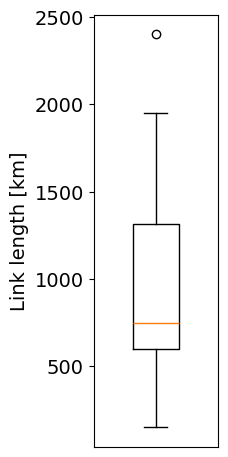

In [38]:
plt.figure(figsize=(2.5, 4.8))
plt.boxplot([topology[x][y]["length"] for x, y in topology.edges()])
plt.ylabel("Link length [km]")
plt.xticks([], [])
plt.xlim([0.8, 1.2])
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_topo_link_length.png")
# plt.savefig(f"figures/{topology_name}_topo_link_length.pdf")
# plt.savefig(f"figures/{topology_name}_topo_link_length.svg")
plt.show()

In [79]:
# for path in topology.graph["ksp"]["Athens", "Glasgow"]:
#     print(path)

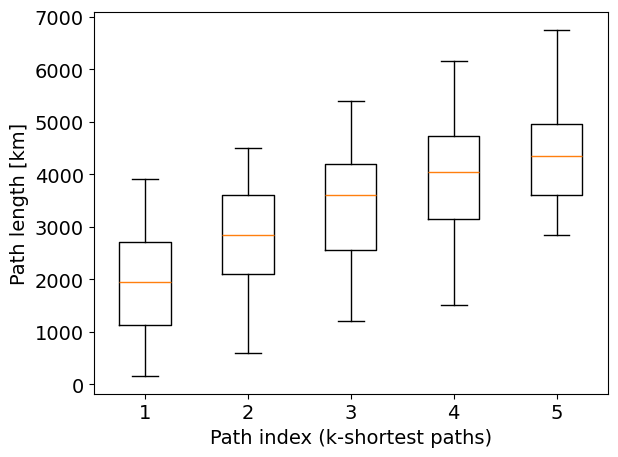

In [39]:
path_lengths = []
for k in range(topology.graph["k_paths"]):
    path_lengths.append([topology.graph["ksp"][x, y][k].length for x, y in itertools.combinations(topology.nodes(), 2)])
plt.figure()
plt.boxplot(path_lengths)
plt.xlabel("Path index (k-shortest paths)")
plt.ylabel("Path length [km]")
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_topo_path_length.png")
# plt.savefig(f"figures/{topology_name}_topo_path_length.pdf")
# plt.savefig(f"figures/{topology_name}_topo_path_length.svg")
plt.show()

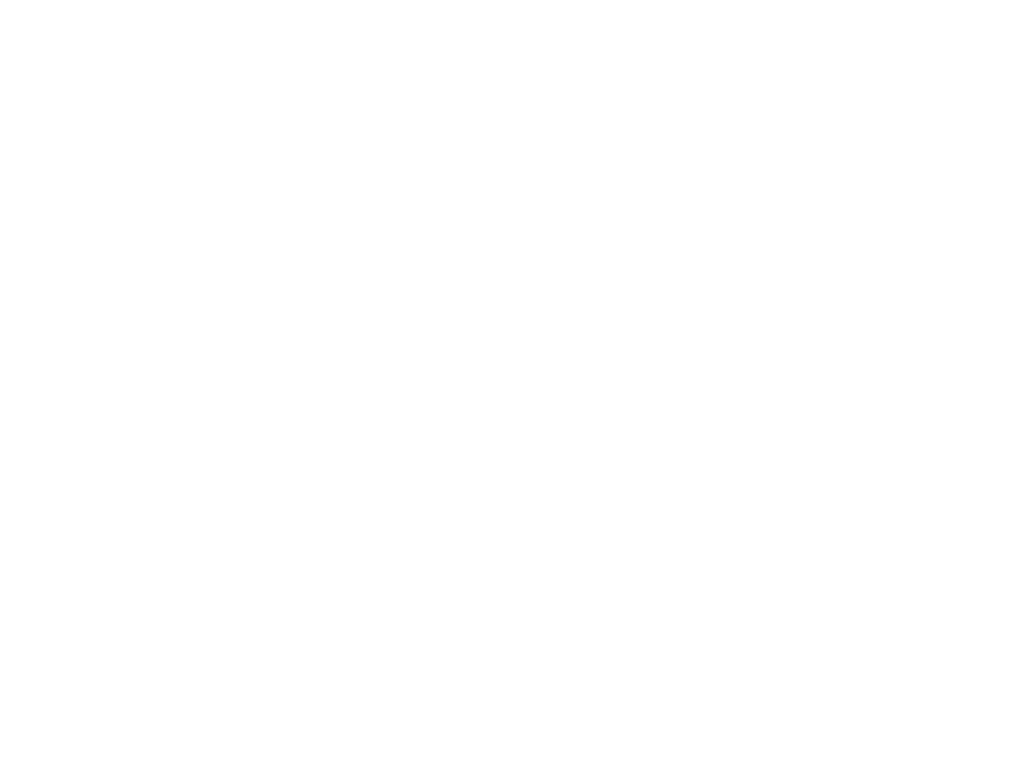

In [47]:
pos = nx.get_node_attributes(topology, "pos")
labels = {x: f"{y:.0f}" for x, y in nx.get_edge_attributes(topology, "length").items()}
plt.figure(figsize=(12.8, 9.6))

# nx.draw_networkx_nodes(topology, pos=pos, node_color="black", node_size=40)
# nx.draw_networkx_labels(topology, pos={x: (y[0], y[1]-0.5) for x, y in pos.items()}, labels={x: x for x in topology.nodes()}, font_color="blue")

# nx.draw_networkx_edges(topology, pos=pos)
# nx.draw_networkx_edge_labels(topology, pos=pos, edge_labels=labels, font_size=8, rotate=False)
plt.axis('off')
# plt.savefig(f"figures/{topology_name}_topo.png")
# plt.savefig(f"figures/{topology_name}_topo.pdf")
# plt.savefig(f"figures/{topology_name}_topo.svg")
plt.show()

## Plots for the launch power

results/lp_episodes_1_NOBEL-EU_-8.0_210.csv
results/lp_episodes_1_NOBEL-EU_-6.0_210.csv
results/lp_episodes_1_NOBEL-EU_-4.0_210.csv


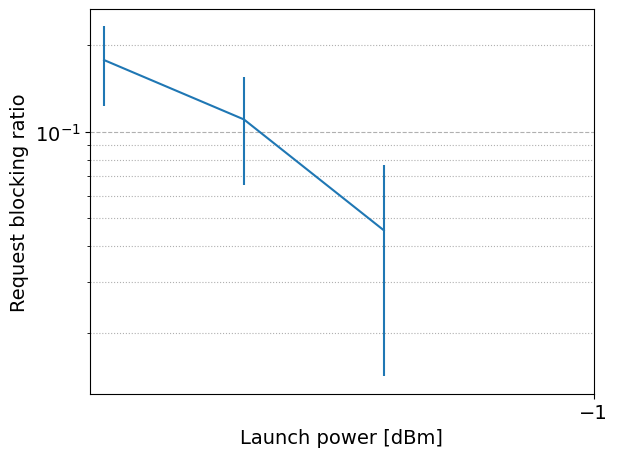

In [68]:
means = []
stdevs = []
topology_name = "nobel-eu"
launch_powers = [-8.0, -6.0, -4.0]
load = 210
for launch_power in launch_powers:
    print(f"results/lp_episodes_1_{topology_name.upper()}_{launch_power}_{load}.csv")
    data_episodes = pd.read_csv(f"results/lp_episodes_1_{topology_name.upper()}_{launch_power}_{load}.csv", skiprows=1)
    data_episodes["episode_service_blocking_rate"] = pd.to_numeric(data_episodes["episode_service_blocking_rate"], errors='coerce')
    means.append(data_episodes["episode_service_blocking_rate"].mean())
    stdevs.append(data_episodes["episode_service_blocking_rate"].std())

plt.figure()
plt.errorbar(launch_powers, means, stdevs)
plt.gca().set_yscale("log")
plt.grid(visible=True, which="major", axis="y", ls="--")
# plt.grid(visible=True, which="major", axis="x", ls=":")
plt.grid(visible=True, which="minor", axis="y", ls=":")
plt.xlabel("Launch power [dBm]")
plt.ylabel("Request blocking ratio")
plt.xticks(range(-1, 1, 5))
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_lp_rbr.png")
# plt.savefig(f"figures/{topology_name}_lp_rbr.pdf")
# plt.savefig(f"figures/{topology_name}_lp_rbr.svg")
plt.show()

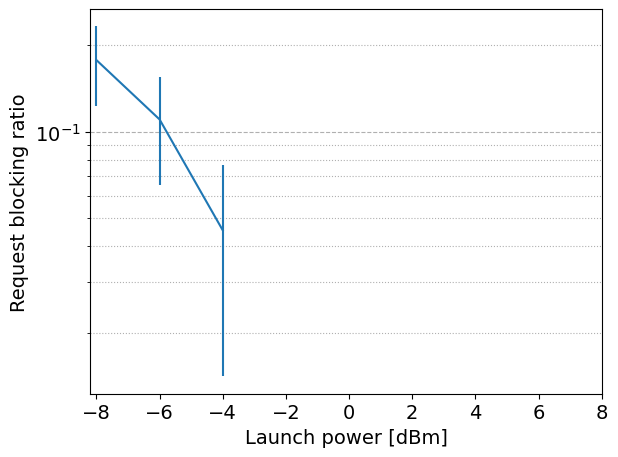

In [69]:
means = []
stdevs = []
for launch_power in launch_powers:
    data_episodes = pd.read_csv(f"results/lp_episodes_1_{topology_name.upper()}_{launch_power}_{load}.csv", skiprows=1)
    means.append(data_episodes["episode_service_blocking_rate"].mean())
    stdevs.append(data_episodes["episode_service_blocking_rate"].std())

plt.figure()
plt.errorbar(launch_powers, means, stdevs)
plt.gca().set_yscale("log")
plt.grid(visible=True, which="major", axis="y", ls="--")
# plt.grid(visible=True, which="major", axis="x", ls=":")
plt.grid(visible=True, which="minor", axis="y", ls=":")
plt.xlabel("Launch power [dBm]")
plt.ylabel("Request blocking ratio")
plt.xticks(range(-8, 9, 2))
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_lp_rbr.png")
# plt.savefig(f"figures/{topology_name}_lp_rbr.pdf")
# plt.savefig(f"figures/{topology_name}_lp_rbr.svg")
plt.show()

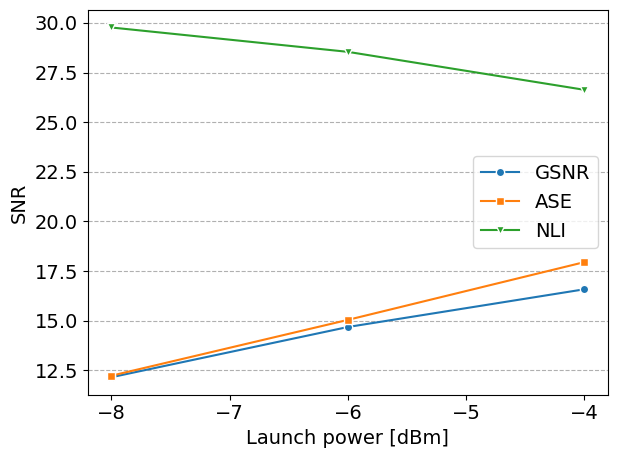

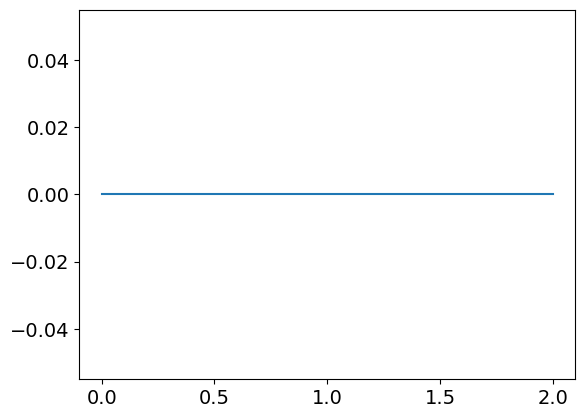

In [70]:
mean_osnr = []
stdev_osnr = []
mean_ase = []
stdev_ase = []
mean_nli = []
stdev_nli = []
disrupted_services = []
best_launch_power = 0
best_mean = 0

for launch_power in launch_powers:
    data_services = pd.read_csv(f"results/lp_services_1_{topology_name.upper()}_{launch_power}_{load}_10.csv", skiprows=1)

    mean = data_services["osnr"].mean()

    if mean > best_mean:
        best_mean = mean
        best_launch_power = launch_power

    mean_osnr.append(mean)
    stdev_osnr.append(data_services["osnr"].std())

    mean_ase.append(data_services["ase"].mean())
    stdev_ase.append(data_services["ase"].std())

    mean_nli.append(data_services["nli"].mean())
    stdev_nli.append(data_services["nli"].std())

    data_episodes = pd.read_csv(f"results/lp_episodes_1_{topology_name.upper()}_{launch_power}_{load}.csv", skiprows=1)
    disrupted_services.append(data_episodes["episode_disrupted_services"].sum())

plt.figure()

# plt.errorbar(launch_powers, mean_osnr, stdev_osnr, label="GSNR")
# plt.errorbar(launch_powers, mean_ase, stdev_ase, label="ASE")
# plt.errorbar(launch_powers, mean_nli, stdev_nli, label="NLI")

plt.plot(launch_powers, mean_osnr, label="GSNR", marker="o", mec="white")
plt.plot(launch_powers, mean_ase, label="ASE", marker="s", mec="white")
plt.plot(launch_powers, mean_nli, label="NLI", marker="v", mec="white")

plt.grid(visible=True, which="major", axis="y", ls="--")
plt.grid(visible=True, which="minor", axis="y", ls=":")
plt.xlabel("Launch power [dBm]")
plt.ylabel("SNR")
plt.legend()
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_lp_snr.png")
# plt.savefig(f"figures/{topology_name}_lp_snr.pdf")
# plt.savefig(f"figures/{topology_name}_lp_snr.svg")
plt.show()

plt.figure()
plt.plot(disrupted_services)
plt.show()

### Launch power service statistics

In [63]:
data_services = pd.read_csv(f"results/lp_services_1_{topology_name.upper()}_{best_launch_power}_{load}_10.csv", skiprows=1)
data_services.describe()

,id,source,destination,bit_rate,path_k,path_length,modulation,min_osnr,osnr,ase,nli,disrupted_services
count,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000
mean,24500.500000,13.489633,13.528020,136.570000,-0.017837,1513.585133,3.995286,13.220099,16.580521,17.948135,26.629990,-0.045469
std,14145.225932,8.086668,8.055884,154.511349,0.329394,853.231632,1.574337,4.596362,5.703432,6.438377,9.079892,0.208333
min,1.000000,0.000000,0.000000,10.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,12250.750000,6.000000,7.000000,10.000000,0.000000,862.412000,3.000000,10.845394,14.762625,14.989714,22.155290,0.000000
50%,24500.500000,13.000000,14.000000,40.000000,0.000000,1420.657000,4.000000,13.240647,17.693522,19.538676,25.788962,0.000000
75%,36750.250000,21.000000,20.000000,100.000000,0.000000,2067.204000,5.000000,16.160898,20.009303,22.069991,30.268375,0.000000
max,49000.000000,27.000000,27.000000,400.000000,4.000000,4227.992000,6.000000,19.013465,29.732935,32.101415,44.833435,0.000000


In [64]:
accepted = data_services[(data_services["path_k"] != -1)]
accepted["margin"] = accepted.apply(lambda x: x.osnr - x.min_osnr, axis=1)
accepted = accepted.drop(["id", "source", "destination"], axis=1)
accepted.describe()

C:\Users\talle\AppData\Local\Temp\ipykernel_40180\740029016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accepted["margin"] = accepted.apply(lambda x: x.osnr - x.min_osnr, axis=1)


,bit_rate,path_k,path_length,modulation,min_osnr,osnr,ase,nli,disrupted_services,margin
count,46772.000000,46772.000000,46772.000000,46772.000000,46772.000000,46772.000000,46772.000000,46772.000000,46772.0,46772.000000
mean,124.034251,0.028949,1585.732906,4.233238,13.897478,17.417975,18.850735,27.946154,0.0,3.520497
std,146.802709,0.255984,805.109925,1.162463,3.470083,4.319047,5.050711,6.947883,0.0,1.423476
min,10.000000,0.000000,157.685000,1.000000,3.719256,3.984452,3.984909,16.435639,0.0,0.265196
25%,10.000000,0.000000,945.095000,4.000000,13.240647,15.711370,16.524308,22.603106,0.0,2.644121
50%,40.000000,0.000000,1500.154000,4.000000,13.240647,17.873294,19.641624,26.077622,0.0,3.473928
75%,100.000000,0.000000,2086.724000,5.000000,16.160898,20.143013,22.202699,30.849133,0.0,4.456019
max,400.000000,4.000000,4227.992000,6.000000,19.013465,29.732935,32.101415,44.833435,0.0,10.719470


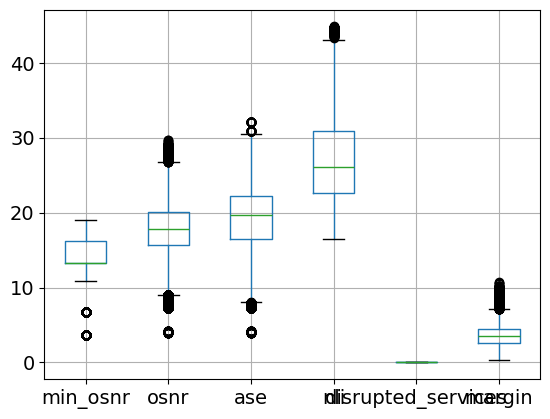

In [65]:
accepted.drop(["path_k", "path_length", "bit_rate", "modulation"], axis=1).boxplot()
plt.show()

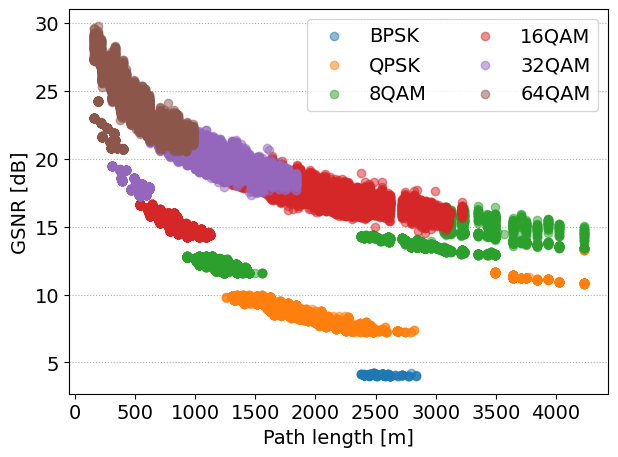

In [67]:
plt.figure()

for modulation in sorted(accepted["modulation"].unique()):
    plt.scatter(accepted[(accepted["modulation"] == modulation)]["path_length"], accepted[(accepted["modulation"] == modulation)]["osnr"], label=modulation, zorder=modulation + 1, alpha=0.5, edgecolors=None)
plt.legend(loc=0, ncols=2, labels=("BPSK", "QPSK", "8QAM", "16QAM", "32QAM", "64QAM"))
plt.xlabel("Path length [m]")
plt.ylabel("GSNR [dB]")
plt.grid(which="major", axis="y", ls=":", zorder=0)
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_lp_gsnr_length.png")
# plt.savefig(f"figures/{topology_name}_lp_gsnr_length.pdf")
# plt.savefig(f"figures/{topology_name}_lp_gsnr_length.svg")
plt.show()

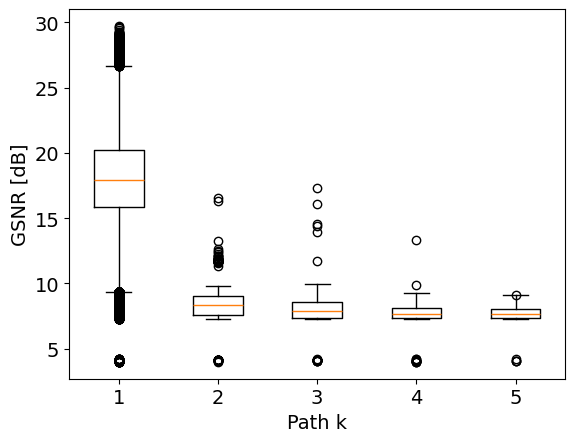

In [72]:
plt.figure()
gsnr = []
for k in range(accepted["path_k"].max()+1):
    gsnr.append(accepted[(accepted["path_k"] == k)]["osnr"].to_numpy())
# plt.scatter(accepted["path_k"], accepted["osnr"])
plt.boxplot(gsnr)
plt.xlabel("Path k")
plt.ylabel("GSNR [dB]")
# plt.savefig(f"figures/{topology_name}_lp_gsnr_k_path.png")
# plt.savefig(f"figures/{topology_name}_lp_gsnr_k_path.pdf")
# plt.savefig(f"figures/{topology_name}_lp_gsnr_k_path.svg")
plt.show()

### Launch power for a certain service

## Plots for impact of margin

In [77]:
topology_name = "nsfnet"
load = 100.0
data_services = pd.read_csv(f"results/mr_services_1_0.0_{topology_name.upper()}_{best_launch_power}_{load}_10.csv", skiprows=1)
# data_services = pd.read_csv(f"results/mr_services_1_0.0_{topology_name.upper()}_-4.0_{load}_10.csv", skiprows=1)
# data_services.describe()
accepted = data_services[(data_services["path_k"] != -1)]
accepted["margin"] = accepted.apply(lambda x: x.osnr - x.min_osnr, axis=1)
# accepted = accepted.drop(["id", "source", "destination"], axis=1)
accepted.describe()

C:\Users\talle\AppData\Local\Temp\ipykernel_40180\1146806638.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accepted["margin"] = accepted.apply(lambda x: x.osnr - x.min_osnr, axis=1)


,id,source,destination,bit_rate,path_k,path_length,modulation,min_osnr,osnr,ase,nli,disrupted_services,margin
count,567.000000,567.000000,567.000000,567.000000,567.0,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.0,567.000000
mean,510.830688,6.970018,7.111111,58.888889,5.0,1503.174603,2.241623,13.881129,18.762941,19.560941,29.451549,0.0,4.881812
std,280.586935,3.764839,3.899805,82.363497,0.0,839.242134,0.600203,3.050027,3.243823,3.623523,5.563550,0.0,1.840915
min,1.000000,0.000000,0.000000,10.000000,5.0,150.000000,2.000000,12.600000,13.526074,13.528730,20.141086,0.0,0.926074
25%,263.500000,4.000000,4.000000,10.000000,5.0,750.000000,2.000000,12.600000,16.544438,17.125280,25.735929,0.0,3.504279
50%,523.000000,7.000000,7.000000,40.000000,5.0,1350.000000,2.000000,12.600000,18.067509,18.968343,28.570229,0.0,4.719482
75%,751.500000,10.000000,11.000000,100.000000,5.0,1950.000000,2.000000,12.600000,20.294427,21.202407,32.797041,0.0,6.125770
max,996.000000,13.000000,13.000000,400.000000,5.0,3600.000000,5.000000,26.400000,30.662089,31.621428,48.865043,0.0,9.895198


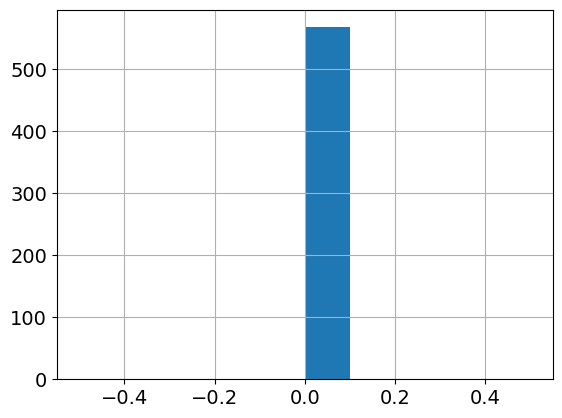

In [78]:
accepted["disrupted_services"].hist()
plt.show()

In [79]:
# data_episodes = pd.read_csv(f"results/mr_episodes_1_0.0_{topology_name.upper()}_{best_launch_power}_{load}.csv", skiprows=1)
data_episodes = pd.read_csv(f"results/mr_episodes_1_0.0_{topology_name.upper()}_-4.0_{load}.csv", skiprows=1)
data_episodes["episode_disrupted_services"]

0    0.0
Name: episode_disrupted_services, dtype: float64

## Plots about dataset generation

In [ ]:
with open(f"results/ds_episodes_{1}_{topology_name.upper()}_{int(best_launch_power)}_{load}.pkl", "rb") as file:
    dataset = pickle.load(file)

## Plots loads

In [82]:
data_loads = None
for strategy in strategies:
    for load in loads:
        if data_loads is None:
            data_loads = pd.read_csv(f"results/load_episodes_{strategy}_{topology_name.upper()}_{best_launch_power}_{load}.0.csv", skiprows=1)
            data_loads["strategy"] = strategy
            data_loads["load"] = load
        else:
            data_load = pd.read_csv(f"results/load_episodes_{strategy}_{topology_name.upper()}_{best_launch_power}_{load}.0.csv", skiprows=1)
            data_load["strategy"] = strategy
            data_load["load"] = load
            data_loads = pd.concat([data_loads, data_load], axis=0, ignore_index=True)
data_loads.head()

,episode,service_blocking_rate,episode_service_blocking_rate,bit_rate_blocking_rate,episode_bit_rate_blocking_rate,modulation_1,modulation_2,modulation_3,modulation_4,modulation_5,modulation_6,episode_disrupted_services,episode_time,strategy,load
0,0,0,0,0.752564,0.752564,0,507,57,16,4,0,0.0,37.80,1,100
1,0,0,0,0.759526,0.759526,0,464,65,25,9,0,0.0,25.38,1,150
2,0,0,0,0.760654,0.760654,0,482,59,26,4,0,0.0,27.43,1,200
3,0,0,0,0.770236,0.770236,0,472,56,35,1,0,0.0,79.60,1,250
4,0,0,0,0.748739,0.748739,0,469,64,37,13,0,0.0,80.60,1,300


In [83]:
data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()

,episode,service_blocking_rate,episode_service_blocking_rate,bit_rate_blocking_rate,episode_bit_rate_blocking_rate,modulation_1,modulation_2,modulation_3,modulation_4,modulation_5,modulation_6,episode_disrupted_services,episode_time,strategy
load,,,,,,,,,,,,,,
100,0.0,0.0,0.0,0.748941,0.748941,0.0,562.0,28.0,0.0,0.0,0.0,0.0,43.42,4.0
150,0.0,0.0,0.0,0.778896,0.778896,0.0,516.0,37.0,0.0,0.0,0.0,0.0,49.61,4.0
200,0.0,0.0,0.0,0.739929,0.739929,0.0,545.0,35.0,0.0,0.0,0.0,0.0,145.00,4.0
250,0.0,0.0,0.0,0.741338,0.741338,0.0,550.0,32.0,0.0,0.0,0.0,0.0,161.57,4.0
300,0.0,0.0,0.0,0.767737,0.767737,0.0,516.0,37.0,0.0,0.0,0.0,0.0,169.64,4.0
350,0.0,0.0,0.0,0.766747,0.766747,0.0,537.0,33.0,1.0,0.0,0.0,0.0,205.69,4.0
400,0.0,0.0,0.0,0.782576,0.782576,0.0,515.0,26.0,1.0,0.0,0.0,0.0,204.85,4.0
450,0.0,0.0,0.0,0.808576,0.808576,0.0,500.0,29.0,0.0,0.0,0.0,0.0,174.23,4.0
500,0.0,0.0,0.0,0.773048,0.773048,0.0,528.0,28.0,1.0,0.0,0.0,0.0,169.73,4.0


C:\Users\talle\AppData\Local\Temp\ipykernel_40180\1882930219.py:21: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.gca().set_yscale("log")


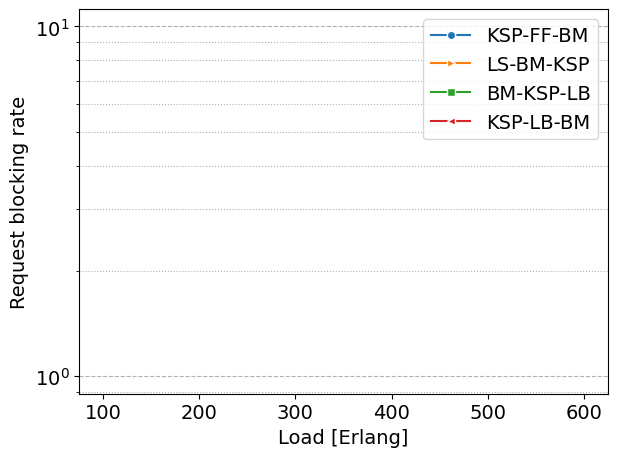

In [94]:
plt.figure()
for ids, strategy in enumerate(strategies):
    # plt.errorbar(
    #     loads,
    #     data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_service_blocking_rate"],
    #     data_loads[(data_loads["strategy"] == strategy)].groupby("load").std()["episode_service_blocking_rate"],
    #     label=strategy, #marker="x"
    # )
    plt.plot(
        loads,
        data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_service_blocking_rate"],
        # data_loads[(data_loads["strategy"] == strategy)].groupby("load").std()["episode_service_blocking_rate"],
        label=strategy,
        marker=markers[ids],
        mec="white",
    )
    # print(strategy, data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_service_blocking_rate"])

plt.xlabel("Load [Erlang]")
plt.ylabel("Request blocking rate")
plt.gca().set_yscale("log")
plt.grid(visible=True, which="major", axis="y", ls="--")
plt.grid(visible=True, which="minor", axis="y", ls=":")
plt.legend(labels=heuristics)
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_load_rbr.png")
# plt.savefig(f"figures/{topology_name}_load_rbr.pdf")
# plt.savefig(f"figures/{topology_name}_load_rbr.svg")
plt.show()

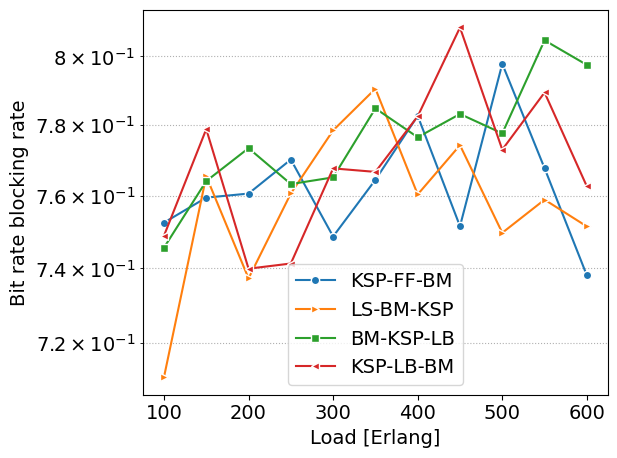

In [91]:
plt.figure()
for ids, strategy in enumerate(strategies):
    plt.plot(
        # loads,
        data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_bit_rate_blocking_rate"],
        # data_loads[(data_loads["strategy"] == strategy)].groupby("load").std()["episode_bit_rate_blocking_rate"],
        label=strategy,
        marker=markers[ids],
        mec="white",
    )

plt.xlabel("Load [Erlang]")
plt.ylabel("Bit rate blocking rate")
plt.gca().set_yscale("log")
plt.grid(visible=True, which="major", axis="y", ls="--")
plt.grid(visible=True, which="minor", axis="y", ls=":")
plt.legend(labels=heuristics)
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_load_brbr.png")
# plt.savefig(f"figures/{topology_name}_load_brbr.pdf")
# plt.savefig(f"figures/{topology_name}_load_brbr.svg")
plt.show()

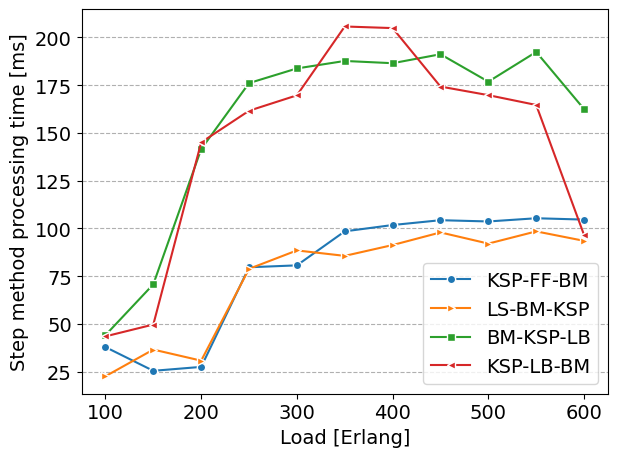

In [93]:
plt.figure()
for ids, strategy in enumerate(strategies):
    # plt.errorbar(
    #     loads,
    #     data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_service_blocking_rate"],
    #     data_loads[(data_loads["strategy"] == strategy)].groupby("load").std()["episode_service_blocking_rate"],
    #     label=strategy, #marker="x"
    # )
    plt.plot(
        loads,
        data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_time"],
        # data_loads[(data_loads["strategy"] == strategy)].groupby("load").std()["episode_service_blocking_rate"],
        label=strategy,
        marker=markers[ids],
        mec="white",
    )
    # print(strategy, data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_service_blocking_rate"])

plt.xlabel("Load [Erlang]")
plt.ylabel("Step method processing time [ms]")
# plt.gca().set_yscale("log")
plt.grid(visible=True, which="major", axis="y", ls="--")
plt.grid(visible=True, which="minor", axis="y", ls=":")
plt.legend(labels=heuristics)
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_load_step_time.png")
# plt.savefig(f"figures/{topology_name}_load_step_time.pdf")
# plt.savefig(f"figures/{topology_name}_load_rbr.svg")
plt.show()